# Models 

> Implementation of key circadian models under the framework of the `DinamicalTrajectory` and `CircadianModel` classes.

In [2]:
#| default_exp models

In [2]:
#| hide
from nbdev.showdoc import *
from fastcore.test import *
from fastcore.basics import *
from circadian.lights import LightSchedule

In [3]:
#| export 
import time as tm
import numpy as np
import pylab as plt
from typing import Tuple
from functools import wraps
from abc import ABC, abstractmethod
from scipy.signal import find_peaks
from circadian.utils import phase_ic_guess

In [4]:
#| export
#| hide
def time_input_checking(time):
    "Checks if time is a valid input"
    if not isinstance(time, np.ndarray):
        raise TypeError("time must be a numpy array")
    if time.ndim != 1:
        raise ValueError("time must be a 1D array")
    if not np.issubdtype(time.dtype, np.number):
        raise TypeError("time must be numeric")
    if not np.all(np.diff(time) > 0):
        raise ValueError("time must be monotonically increasing")
    return True

def state_input_checking(state, time):
    "Checks if state is a valid input"
    if not isinstance(state, np.ndarray):
        raise TypeError("states must be a numpy array")
    if state.ndim < 1:
        raise ValueError("states must have at least 1 dimension")
    if state.ndim > 3:
        raise ValueError("states must have at most 3 dimensions")
    if state.shape[0] != len(time):
        raise ValueError("states must have the same length as time")
    if not np.issubdtype(state.dtype, np.number):
        raise TypeError("states must be numeric")
    return True

In [5]:
#| export
#| hide
class DynamicalTrajectory:
    "A class to store solutions of differential equation models that contains both the time points and the states"
    def __init__(self, 
                 time: np.ndarray, # time points
                 states: np.ndarray # state at time points
                 ) -> None:
        # input checking
        time_input_checking(time)
        state_input_checking(states, time)
        
        self.time = time
        self.states = states
        self.num_states = states.shape[1]
        if states.ndim >= 3:
            self.batch_size = states.shape[2]
        else:
            self.batch_size = 1

In [6]:
#| hide
# test DynamicalTrajectory's constructor
total_timepoints = 1000
variables = 2
time = np.linspace(0, 10, total_timepoints)
states = np.zeros((total_timepoints, variables))
states[:, 0] = np.sin(time)
states[:, 1] = np.cos(time)
traj = DynamicalTrajectory(time, states)
# test attributes
test_eq(traj.num_states, variables)
test_eq(traj.batch_size, 1)
test_eq(traj.time, time)
test_eq(traj.states, states)
# test batch handling
batches = 5
batch_states = np.zeros((total_timepoints, variables, batches))
batch_states[:, 0, :] = np.sin(time)[:, None]
batch_states[:, 1, :] = np.cos(time)[:, None]
batch_traj = DynamicalTrajectory(time, batch_states)
test_eq(batch_traj.num_states, variables)
test_eq(batch_traj.batch_size, batches)
test_eq(batch_traj.time, time)
test_eq(batch_traj.states, batch_states)
# test error handling
test_fail(lambda: DynamicalTrajectory(1, np.array([1, 2])), contains="time must be a numpy array")
test_fail(lambda: DynamicalTrajectory(np.array([[1, 2], [1, 2]]), np.array([1, 2]) ), contains="time must be a 1D array")
test_fail(lambda: DynamicalTrajectory(np.array(["1", "2"]), np.array([1, 2])), contains="time must be numeric")
test_fail(lambda: DynamicalTrajectory(np.array([2, 1]), np.array([1, 2])), contains="time must be monotonically increasing")
test_fail(lambda: DynamicalTrajectory(np.array([1, 2]), 1), contains="states must be a numpy array")
test_fail(lambda: DynamicalTrajectory(np.array([1, 2]), np.array(1)), contains="states must have at least 1 dimension")
test_fail(lambda: DynamicalTrajectory(np.array([1, 2]), np.zeros((1,1,1,1))), contains="states must have at most 3 dimensions")
test_fail(lambda: DynamicalTrajectory(np.array([1, 2, 3]), np.array([1, 2])), contains="states must have the same length as time")
test_fail(lambda: DynamicalTrajectory(np.array([1, 2]), np.array([1, 2, 3])), contains="states must have the same length as time")
test_fail(lambda: DynamicalTrajectory(np.array([1, 2]), np.array(["1", "2"])), contains="states must be numeric")

In [7]:
#| export
#| hide
@patch_to(DynamicalTrajectory)
def __call__(self, timepoint: float) -> np.ndarray: # state of the system
    "Return the state at time t, linearly interpolated"
    # timepoint input checking
    if not isinstance(timepoint, (int, float)):
        raise TypeError("timepoint must be int or float")
    if timepoint < self.time[0] or timepoint > self.time[-1]:
        raise ValueError("timepoint must be within the time range")
    
    if self.batch_size == 1:
        values = np.zeros(self.num_states)
        for idx in range(self.num_states):
            values[idx] = np.interp(timepoint, self.time, self.states[..., idx])
    else:
        values = np.zeros((self.num_states, self.batch_size))
        for idx in range(self.num_states):
            for batch_idx in range(self.batch_size):
                values[idx, batch_idx] = np.interp(timepoint, self.time, self.states[..., idx, batch_idx])
    
    return values

In [8]:
#| hide
# test DynamicalTrajectory's __call__
total_timepoints = 1000
variables = 2
time = np.linspace(0, 10, total_timepoints)
states = np.zeros((total_timepoints, variables))
states[:, 0] = np.sin(time)
states[:, 1] = np.cos(time)
traj = DynamicalTrajectory(time, states)
interpolation_error = np.abs(np.sum(traj(5.0) - (np.sin(5.0), np.cos(5.0))))
test_eq(interpolation_error < 1e-4, True)
# handle batch
batches = 5
batch_states = np.zeros((total_timepoints, variables, batches))
batch_states[:, 0, :] = np.sin(time)[:, None]
batch_states[:, 1, :] = np.cos(time)[:, None]
batch_traj = DynamicalTrajectory(time, batch_states)
interpolation_error = np.abs(np.sum((batch_traj(0.5)[0] - np.sin(0.5)) + (batch_traj(0.5)[1] - np.cos(0.5))))
test_eq(interpolation_error < 1e-4, True)
# test error handling
test_fail(lambda: traj("1"), contains="timepoint must be int or float")
test_fail(lambda: traj(11), contains="timepoint must be within the time range")

In [9]:
#| export
#| hide
@patch_to(DynamicalTrajectory)
def __getitem__(self, time_idx: int) -> Tuple[float, np.ndarray]:
    "Return the time and state at index idx"
    # idx input checking
    if not isinstance(time_idx, int):
        raise TypeError("idx must be int")
    if time_idx < -1 or time_idx >= len(self.time):
        raise ValueError(f"idx must be within 0 and {len(self.time)-1}, got {time_idx}")
    
    return self.time[time_idx], self.states[time_idx, ...]

In [10]:
#| hide
# test DynamicalTrajectory's __getitem__
total_timepoints = 1000
variables = 2
time = np.linspace(0, np.pi, total_timepoints)
states = np.zeros((total_timepoints, variables))
states[:, 0] = np.sin(time)
states[:, 1] = np.cos(time)
traj = DynamicalTrajectory(time, states)
test_eq(traj[0], (0.0, np.array([0.0, 1.0])))
states = traj[-1][1]
difference = np.abs(np.sum(states - (np.sin(np.pi), np.cos(np.pi))))
test_eq(difference < 1e-4, True)
# handle batch
batches = 5
batch_states = np.zeros((total_timepoints, variables, batches))
batch_states[:, 0, :] = np.sin(time)[:, None]
batch_states[:, 1, :] = np.cos(time)[:, None]
batch_traj = DynamicalTrajectory(time, batch_states)
test_eq(batch_traj[0][0], 0.0)
test_eq(np.all(batch_traj[0][1][0]==np.zeros(batches)), True)
test_eq(np.all(batch_traj[0][1][1]==np.ones(batches)), True)
# test error handling
test_fail(lambda: traj["1"], contains="idx must be int")
test_fail(lambda: traj[-2], contains="idx must be within 0 and")
test_fail(lambda: traj[1000], contains="idx must be within 0 and")

In [11]:
#| export
#| hide
@patch_to(DynamicalTrajectory)
def __len__(self) -> int:
    return len(self.time)

In [12]:
#| hide
# test DynamicalTrajectory's __len__
total_timepoints = 1000
variables = 2
time = np.linspace(0, np.pi, total_timepoints)
states = np.zeros((total_timepoints, variables))
states[:, 0] = np.sin(time)
states[:, 1] = np.cos(time)
traj = DynamicalTrajectory(time, states)
test_eq(len(traj), total_timepoints)
# handle batch
batches = 5
batch_states = np.zeros((total_timepoints, variables, batches))
batch_states[:, 0, :] = np.sin(time)[:, None]
batch_states[:, 1, :] = np.cos(time)[:, None]
batch_traj = DynamicalTrajectory(time, batch_states)
test_eq(len(batch_traj), total_timepoints)

In [13]:
#| export
#| hide
@patch_to(DynamicalTrajectory)
def get_batch(self, batch_idx: int) -> 'DynamicalTrajectory':
    "Obtain the trajectory for a single batch"
    # batch_idx input checking
    if not isinstance(batch_idx, int):
        raise TypeError("batch_idx must be int")
    if batch_idx < -1 or batch_idx >= self.batch_size:
        raise ValueError(f"batch_idx must be within -1 and {self.batch_size-1}, got {batch_idx}")
    if self.states.ndim >= 3:
        return DynamicalTrajectory(self.time, self.states[:, :, batch_idx])
    else:
        # no batch dimension
        return DynamicalTrajectory(self.time, self.states)

In [14]:
#| hide
# test DynamicalTrajectory's get_batch
total_timepoints = 1000
variables = 2
time = np.linspace(0, np.pi, total_timepoints)
states = np.zeros((total_timepoints, variables))
states[:, 0] = np.sin(time)
states[:, 1] = np.cos(time)
traj = DynamicalTrajectory(time, states)
test_eq(traj.get_batch(0).batch_size, 1)
test_eq(traj.get_batch(0).num_states, variables)
test_eq(traj.get_batch(0).time, time)
test_eq(traj.get_batch(0).states, states)
test_eq(traj.get_batch(0).states.ndim, 2)
test_eq(traj.get_batch(0).states.shape, (total_timepoints, variables))
# handle batch
batches = 5
batch_states = np.zeros((total_timepoints, variables, batches))
batch_states[:, 0, :] = np.sin(time)[:, None]
batch_states[:, 1, :] = np.cos(time)[:, None]
batch_traj = DynamicalTrajectory(time, batch_states)
test_eq(batch_traj.get_batch(0).batch_size, 1)
test_eq(batch_traj.get_batch(0).num_states, variables)
test_eq(batch_traj.get_batch(0).time, time)
test_eq(batch_traj.get_batch(0).states, batch_states[:, :, 0])
test_eq(batch_traj.get_batch(0).states.ndim, 2)
test_eq(batch_traj.get_batch(0).states.shape, (total_timepoints, variables))
test_eq(batch_traj.get_batch(4).batch_size, 1)
test_eq(batch_traj.get_batch(4).num_states, variables)
test_eq(batch_traj.get_batch(4).time, time)
test_eq(batch_traj.get_batch(4).states, batch_states[:, :, 0])
test_eq(batch_traj.get_batch(4).states.ndim, 2)
test_eq(batch_traj.get_batch(4).states.shape, (total_timepoints, variables))
test_eq(batch_traj.get_batch(-1).states, batch_traj.get_batch(4).states)
# test error handling
test_fail(lambda: traj.get_batch("1"), contains="batch_idx must be int")
test_fail(lambda: traj.get_batch(5), contains="batch_idx must be within -1 and")
test_fail(lambda: traj.get_batch(-2), contains="batch_idx must be within -1 and")

In [15]:
#| export
#| hide
@patch_to(DynamicalTrajectory)
# String method
def __str__(self) -> str:
    time_str = np.array2string(self.time, precision=2, separator=", ", threshold=20)
    states_str = np.array2string(self.states, precision=2, separator=", ", threshold=20)
    output = f"Time:\n{time_str}\n"
    output += f"States:\n{states_str}"
    return output

In [16]:
#| export
#| hide
def parameter_input_checking(parameters):
    "Checks if parameters is a valid input for a circadian model"
    if not isinstance(parameters, dict):
        raise TypeError("parameters must be a dictionary")
    if len(parameters) == 0:
        raise ValueError("parameters must not be empty")
    for key, value in parameters.items():
        if not isinstance(key, str):
            raise TypeError("keys of parameters must be strings")
        if not isinstance(value, (int, float)):
            raise TypeError("values of parameters must be numeric")
    
    return True

def light_input_checking(light):
    "Checks if light is a valid input for a circadian model"
    if not isinstance(light, np.ndarray):
        raise TypeError("light must be a numpy array")
    if light.ndim != 1:
        raise ValueError("light must be a 1D array")
    if not np.issubdtype(light.dtype, np.number):
        raise TypeError("light must be numeric")
    if not np.all(light >= 0):
        raise ValueError("light intensity must be nonnegative")
    return True


def num_states_input_checking(num_states):
    "Checks if num_states is a valid input for a circadian model"
    if not isinstance(num_states, int):
        raise TypeError("num_states must be an integer")
    if num_states < 1:
        raise ValueError("num_states must be positive")
    return True


def initial_conditions_input_checking(initial_conditions, num_states):
    "Checks if initial_conditions is a valid input for a circadian model"
    if not isinstance(initial_conditions, np.ndarray):
        raise TypeError("initial_conditions must be a numpy array")
    if not np.issubdtype(initial_conditions.dtype, np.number):
        raise TypeError("initial_conditions must be numeric")
    if initial_conditions.shape[0] != num_states:
        raise ValueError(f"initial_conditions must have length {num_states}")
    return True

In [17]:
#| export
#| hide
class CircadianModel(ABC):
    "Abstract base class for circadian models that defines the common interface for all implementations"
    def __init__(self, 
                 default_params: dict, # default parameters for the model
                 num_states: int, # number of independent variables in the model
                 default_initial_conditions: np.ndarray # default initial conditions for the model
                 ) -> None:
        "Creates a new instance of the model"
        parameter_input_checking(default_params)
        num_states_input_checking(num_states)
        initial_conditions_input_checking(default_initial_conditions, num_states)
        self.__default_params = default_params
        self.__num_states = num_states
        self.__default_initial_conditions = default_initial_conditions
        self._trajectory = None
        self.set_parameters(default_params)
    
    def set_parameters(self, 
                       param_dict: dict # dictionary of parameters for the model
                       ) -> None:
        "Sets the parameters for the model as attributes from a dictionary"
        self.parameter_dict = param_dict
        for key, value in param_dict.items():
            setattr(self, key, value)

    def get_parameters(self) -> dict:
        "Returns the parameters for the model as a dictionary"
        return self.parameter_dict

    @property
    def _default_params(self) -> dict:
        return self.__default_params

    @_default_params.setter
    def _default_params(self, value):
        self.set_parameters(value)
        self.__default_params = value

    @property
    def _num_states(self) -> int: # number of independent variables in the model
        return self.__num_states

    @_num_states.setter
    def _num_states(self, value):
        self.__num_states = value

    @property
    def _default_initial_conditions(self) -> np.ndarray:
        return self.__default_initial_conditions
    
    @_default_initial_conditions.setter
    def _default_initial_conditions(self, value):
        self.__default_initial_conditions = value

    @property
    def trajectory(self) -> DynamicalTrajectory:
        return self._trajectory
    
    @trajectory.setter
    def trajectory(self, value):
        self._trajectory = value

In [18]:
#| hide
# test CircadianModel's constructor
default_params = {"a": 1, "b": 2}
num_states = 3
default_initial_conditions = np.array([1, 2, 3])
model = CircadianModel(default_params, num_states, default_initial_conditions)
# test attributes
test_eq(model._default_params, default_params)
test_eq(model._num_states, num_states)
test_eq(model._default_initial_conditions, default_initial_conditions)
test_eq(model.parameter_dict, default_params)
test_eq(model.a, 1)
test_eq(model.b, 2)
test_eq(model.trajectory, None)
# test error handling
test_fail(lambda: CircadianModel(1, num_states, default_initial_conditions), contains="parameters must be a dictionary")
test_fail(lambda: CircadianModel({}, num_states, default_initial_conditions), contains="parameters must not be empty")
test_fail(lambda: CircadianModel({"a": 1, 2: 3}, num_states, default_initial_conditions), contains="keys of parameters must be strings")
test_fail(lambda: CircadianModel({"a": 1, "b": "2"}, num_states, default_initial_conditions), contains="values of parameters must be numeric")
test_fail(lambda: CircadianModel(default_params, 0, default_initial_conditions), contains="num_states must be positive")
test_fail(lambda: CircadianModel(default_params, num_states, 1), contains="initial_conditions must be a numpy array")
test_fail(lambda: CircadianModel(default_params, num_states, np.array([1, 2])), contains="initial_conditions must have length")
test_fail(lambda: CircadianModel(default_params, num_states, np.array(["1", "2", "3"])), contains="initial_conditions must be numeric")
test_fail(lambda: CircadianModel(default_params, num_states, np.array([1, 2, 3, 4])), contains="initial_conditions must have length")

In [19]:
#| export
#| hide
@patch_to(CircadianModel)
def get_parameters_array(self)-> np.array:
    "Returns the parameters for the model"
    parameter_array = np.zeros(len(self.parameter_dict))
    for idx, value in enumerate(self.parameter_dict.values()):
        parameter_array[idx] = value
    return parameter_array

In [20]:
#| hide
# test CircadianModel's get_parameters_array
default_params = {"a": 1, "b": 2}
num_states = 3
default_initial_conditions = np.array([1, 2, 3])
model = CircadianModel(default_params, num_states, default_initial_conditions)
test_eq(model.get_parameters_array(), np.array([1, 2]))

In [21]:
#| export
#| hide
@patch_to(CircadianModel)
def derv(self,
         state: np.ndarray, # dynamical state of the model
         light: float, # light intentisty at time t in lux
         ) -> np.ndarray:
    "Right-hand-side of the differential equation model"
    return np.ones_like(state)

In [22]:
#| export
#| hide
@patch_to(CircadianModel)
def step_rk4(self,
             state: np.ndarray, # dynamical state of the model
             light: float, # light intentisty at time t in lux
             dt: float # step size in hours 
             ) -> np.ndarray:
    "Integrate the state of the model for one timestep using a fourth-order Runge-Kutta algorithm. Assumes a constant light value for the time step"
    k1 = self.derv(state, light)
    k2 = self.derv(state + k1 * dt / 2.0, light)
    k3 = self.derv(state + k2 * dt / 2.0, light)
    k4 = self.derv(state + k3 * dt, light)
    state = state + (dt / 6.0) * (k1 + 2.0*k2 + 2.0*k3 + k4)
    return state

In [23]:
#| hide
# test CircadianModel's step_rk4
default_params = {"a": 1, "b": 2}
num_states = 3
default_initial_conditions = np.array([1, 2, 3])
model = CircadianModel(default_params, num_states, default_initial_conditions)
light = 1.0
dt = 0.1
test_eq(np.all(model.step_rk4(default_initial_conditions, light, dt) == np.array([1.1, 2.1, 3.1])), True)

In [24]:
#| export
#| hide
@patch_to(CircadianModel)
def integrate_model(self,
                    time: np.ndarray, # time points for integration. Time difference between consecutive values determines step size of the solver
                    light_est: np.ndarray, # light intensity estimates. Should be the same length as time
                    initial_conditions: np.ndarray=None, # initial state of the model
                    ) -> DynamicalTrajectory:
    "Solve the model for specific timepoints given a light estimate and initial conditions"
    # input checking
    time_input_checking(time)
    light_input_checking(light_est)
    if initial_conditions is None:
        initial_conditions = self._default_initial_conditions
    else:
        initial_conditions_input_checking(initial_conditions, self._num_states)
    
    n = len(time)
    sol = np.zeros((n, *initial_conditions.shape))
    sol[0,...] = initial_conditions
    state = initial_conditions
    for idx in range(1, n):
        dt = time[idx] - time[idx-1]
        state = self.step_rk4(state, light_est[idx], dt)
        sol[idx,...] = state
    
    self._trajectory = DynamicalTrajectory(time, sol)
    return self._trajectory

In [25]:
#| hide
# test CircadianModel's integrate_model
default_params = {"a": 1, "b": 2}
num_states = 3
default_initial_conditions = np.array([1, 2, 3])
model = CircadianModel(default_params, num_states, default_initial_conditions)
time = np.linspace(0, 10, 1000)
light = np.ones_like(time)
model.integrate_model(time, light, default_initial_conditions)
test_eq(model.trajectory.num_states, num_states)
test_eq(model.trajectory.batch_size, 1)
test_eq(model.trajectory.time, time)
state_0_error = np.abs(np.sum(model.trajectory.states[:, 0] - time - 1))
state_1_error = np.abs(np.sum(model.trajectory.states[:, 1] - time - 2))
state_2_error = np.abs(np.sum(model.trajectory.states[:, 2] - time - 3))
test_eq(state_0_error < 1e-10, True)
test_eq(state_1_error < 1e-10, True)
test_eq(state_2_error < 1e-10, True)
# handle batches
batches = 5
batch_initial_conditions = np.zeros((num_states, batches))
batch_initial_conditions[:, 1] = 1
batch_initial_conditions[:, 2] = 2
batch_initial_conditions[:, 3] = 3
batch_initial_conditions[:, 4] = 4
model.integrate_model(time, light, batch_initial_conditions)
for batch in range(batches):
    batch_trajectory = model.trajectory.get_batch(batch)
    test_eq(batch_trajectory.num_states, num_states)
    test_eq(batch_trajectory.time, time)
    state_0_error = np.abs(np.sum(batch_trajectory.states[:, 0] - time - batch))
    state_1_error = np.abs(np.sum(batch_trajectory.states[:, 1] - time - batch))
    state_2_error = np.abs(np.sum(batch_trajectory.states[:, 2] - time - batch))
    test_eq(state_0_error < 1e-10, True)
    test_eq(state_1_error < 1e-10, True)
    test_eq(state_2_error < 1e-10, True)
# test error handling
test_fail(lambda: model.integrate_model(1, light, default_initial_conditions), contains="time must be a numpy array")
test_fail(lambda: model.integrate_model(np.array([[1, 2], [1, 2]]), light, default_initial_conditions), contains="time must be a 1D array")
test_fail(lambda: model.integrate_model(np.array(["1", "2"]), light, default_initial_conditions), contains="time must be numeric")
test_fail(lambda: model.integrate_model(np.array([2, 1]), light, default_initial_conditions), contains="time must be monotonically increasing")
test_fail(lambda: model.integrate_model(time, 1, default_initial_conditions), contains="light must be a numpy array")
test_fail(lambda: model.integrate_model(time, np.array([[1, 2], [1, 2]]), default_initial_conditions), contains="light must be a 1D array")
test_fail(lambda: model.integrate_model(time, np.array(["1", "2"]), default_initial_conditions), contains="light must be numeric")
test_fail(lambda: model.integrate_model(time, np.array([-1, 1]), default_initial_conditions), contains="light intensity must be nonnegative")
test_fail(lambda: model.integrate_model(time, light, 1), contains="initial_conditions must be a numpy array")
test_fail(lambda: model.integrate_model(time, light, np.array([1, 2])), contains="initial_conditions must have length")
test_fail(lambda: model.integrate_model(time, light, np.array(["1", "2", "3"])), contains="initial_conditions must be numeric")
test_fail(lambda: model.integrate_model(time, light, np.array([1, 2, 3, 4])), contains="initial_conditions must have length")

In [26]:
#| export
#| hide
@patch_to(CircadianModel)
def __call__(self,
             time: np.ndarray, # time points for integration. Time difference between each consecutive pair of values determines step size of the solver
             light_est: np.ndarray, # light intensity estimates. Should be the same length as time
             initial_conditions: np.ndarray=None, # initial state of the model
             ):
    "Wrapper to integrate_model"
    return self.integrate_model(time, light_est, initial_conditions)

In [27]:
#| hide
# test CircadianModel's __call__
default_params = {"a": 1, "b": 2}
num_states = 3
default_initial_conditions = np.array([1, 2, 3])
model = CircadianModel(default_params, num_states, default_initial_conditions)
time = np.linspace(0, 10, 1000)
light = np.ones_like(time)
model(time, light, default_initial_conditions)
test_eq(model.trajectory.num_states, num_states)
test_eq(model.trajectory.batch_size, 1)
test_eq(model.trajectory.time, time)
state_0_error = np.abs(np.sum(model.trajectory.states[:, 0] - time - 1))
state_1_error = np.abs(np.sum(model.trajectory.states[:, 1] - time - 2))
state_2_error = np.abs(np.sum(model.trajectory.states[:, 2] - time - 3))
test_eq(state_0_error < 1e-10, True)
test_eq(state_1_error < 1e-10, True)
test_eq(state_2_error < 1e-10, True)
# handle batches
batches = 5
batch_initial_conditions = np.zeros((num_states, batches))
batch_initial_conditions[:, 1] = 1
batch_initial_conditions[:, 2] = 2
batch_initial_conditions[:, 3] = 3
batch_initial_conditions[:, 4] = 4
model(time, light, batch_initial_conditions)
for batch in range(batches):
    batch_trajectory = model.trajectory.get_batch(batch)
    test_eq(batch_trajectory.num_states, num_states)
    test_eq(batch_trajectory.time, time)
    state_0_error = np.abs(np.sum(batch_trajectory.states[:, 0] - time - batch))
    state_1_error = np.abs(np.sum(batch_trajectory.states[:, 1] - time - batch))
    state_2_error = np.abs(np.sum(batch_trajectory.states[:, 2] - time - batch))
    test_eq(state_0_error < 1e-10, True)
    test_eq(state_1_error < 1e-10, True)
    test_eq(state_2_error < 1e-10, True)
# test error handling
test_fail(lambda: model(1, light, default_initial_conditions), contains="time must be a numpy array")
test_fail(lambda: model(np.array([[1, 2], [1, 2]]), light, default_initial_conditions), contains="time must be a 1D array")
test_fail(lambda: model(np.array(["1", "2"]), light, default_initial_conditions), contains="time must be numeric")
test_fail(lambda: model(np.array([2, 1]), light, default_initial_conditions), contains="time must be monotonically increasing")
test_fail(lambda: model(time, 1, default_initial_conditions), contains="light must be a numpy array")
test_fail(lambda: model(time, np.array([[1, 2], [1, 2]]), default_initial_conditions), contains="light must be a 1D array")
test_fail(lambda: model(time, np.array(["1", "2"]), default_initial_conditions), contains="light must be numeric")
test_fail(lambda: model(time, np.array([-1, 1]), default_initial_conditions), contains="light intensity must be nonnegative")
test_fail(lambda: model(time, light, 1), contains="initial_conditions must be a numpy array")
test_fail(lambda: model(time, light, np.array([1, 2])), contains="initial_conditions must have length")
test_fail(lambda: model(time, light, np.array(["1", "2", "3"])), contains="initial_conditions must be numeric")
test_fail(lambda: model(time, light, np.array([1, 2, 3, 4])), contains="initial_conditions must have length")

In [28]:
#| export
#| hide
@patch_to(CircadianModel)
def dlmos(self) -> np.ndarray: # array of times when dlmo occurs 
    "Finds the Dim Light Melatonin Onset (DLMO) markers for the model along a trajectory"
    pass

In [29]:
#| export
#| hide
@patch_to(CircadianModel)
def cbt(self) -> np.ndarray: # array of times when the cbt occurs
    "Finds the core body temperature minumum markers for the model along a trajectory"
    pass

In [31]:
#| export
#| hide
@patch_to(CircadianModel)
def amplitude(self,
              time: float, # timepoint to calculate the amplitude at
              ) -> float:
    "Calculates the amplitude of the model at a given timepoint"
    pass

In [32]:
#| export
#| hide
@patch_to(CircadianModel)
def phase(self,
          time: float # timepoint to calculate the phase at
          ) -> float:
    "Calculates the phase of the model at a given timepoint"
    pass

In [33]:
#| export
#| hide
@patch_to(CircadianModel)
def initial_conditions_loop(self,
                            time: np.ndarray, # time points for integration. Time difference between each consecutive pair of values determines step size of the solver
                            light_est: np.ndarray, # light intensity estimates. Should be the same length as time
                            num_loops: int=30 # number of times to loop the light_estimate
                            ) -> np.ndarray: 
    "Estimate initial conditions by looping the given light_estimate. Assumes the schedule repeats periodically"
    # input checking
    time_input_checking(time)
    light_input_checking(light_est)
    if not isinstance(num_loops, int):
        raise TypeError("num_loops must be int")
    if num_loops < 1:
        raise ValueError("num_loops must be positive")
    
    initial_conditions = self._default_initial_conditions
    for _ in range(num_loops):
        sol = self.integrate_model(time, light_est, initial_conditions).states
        initial_conditions = sol[-1, ...]
    return initial_conditions

In [34]:
#| hide
# test CircadianModel's initial_conditions_loop
default_params = {"a": 1, "b": 2}
num_states = 3
default_initial_conditions = np.array([1, 2, 3])
model = CircadianModel(default_params, num_states, default_initial_conditions)
time = np.linspace(0, 10, 1000)
light = np.ones_like(time)
model(time, light, default_initial_conditions)
loops = 2
new_initial_conditions = model.initial_conditions_loop(time, light, loops)
test_eq(new_initial_conditions.shape, default_initial_conditions.shape)
ground_truth = default_initial_conditions + loops * time[-1]
test_eq(np.all(np.isclose(ground_truth, new_initial_conditions)), True)
# test error handling
test_fail(lambda: model.initial_conditions_loop(1, light, loops), contains="time must be a numpy array")
test_fail(lambda: model.initial_conditions_loop(np.array([[1, 2], [1, 2]]), light, loops), contains="time must be a 1D array")
test_fail(lambda: model.initial_conditions_loop(np.array(["1", "2"]), light, loops), contains="time must be numeric")
test_fail(lambda: model.initial_conditions_loop(np.array([2, 1]), light, loops), contains="time must be monotonically increasing")
test_fail(lambda: model.initial_conditions_loop(time, 1, loops), contains="light must be a numpy array")
test_fail(lambda: model.initial_conditions_loop(time, np.array([[1, 2], [1, 2]]), loops), contains="light must be a 1D array")
test_fail(lambda: model.initial_conditions_loop(time, np.array(["1", "2"]), loops), contains="light must be numeric")
test_fail(lambda: model.initial_conditions_loop(time, np.array([-1, 1]), loops), contains="light intensity must be nonnegative")
test_fail(lambda: model.initial_conditions_loop(time, light, 1.0), contains="num_loops must be int")
test_fail(lambda: model.initial_conditions_loop(time, light, 0), contains="num_loops must be positive")

In [35]:
#| export
#| hide
class Forger99(CircadianModel): 
    "Implementation of Forger's 1999 model from the article 'A simpler model of the human circadian pacemaker'"
    def __init__(self, params=None):
        default_params = {
            'taux': 24.2, 'mu': 0.23, 'G': 33.75, 
            'alpha_0': 0.05, 'delta': 0.0075, 'p': 0.50, 
            'I0': 9500.0, 'kparam': 0.55,
            }
        num_states = 3
        default_initial_conditions = np.array([-1.00982605,  0.00125715,  0.0])
        super(Forger99, self).__init__(default_params, num_states, default_initial_conditions)
        if params is not None:
            self.set_parameters(params)

    def __repr__(self) -> str:
        return self.__str__()
    
    def __str__(self) -> str:
        return "Forger99"

In [87]:
#| hide
# test Forger99's constructor
model = Forger99()
# test attributes
true_default_params = {
    'taux': 24.2, 'mu': 0.23, 'G': 33.75,
    'alpha_0': 0.05, 'delta': 0.0075, 'p': 0.50,
    'I0': 9500.0, 'kparam': 0.55}
test_eq(model._default_params, true_default_params)
true_initial_conditions = np.array([-1.00982605,  0.00125715,  0.0])
test_eq(model._default_initial_conditions, true_initial_conditions)
test_eq(model.parameter_dict, true_default_params)
test_eq(model._num_states, 3)
for key, value in true_default_params.items():
    test_eq(getattr(model, key), value)
# test initialization with custom parameters
custom_params = {
    'taux': 1.0, 'mu': 2.0, 'G': 3.0,
    'alpha_0': 4.0, 'delta': 5.0, 'p': 6.0,
    'I0': 7.0, 'kparam': 8.0}
model = Forger99(custom_params)
# test attributes
test_eq(model._default_params, true_default_params)
test_eq(model._default_initial_conditions, true_initial_conditions)
test_eq(model.parameter_dict, custom_params)
test_eq(model._num_states, 3)
for key, value in custom_params.items():
    test_eq(getattr(model, key), value)

In [36]:
#| export
#| hide
@patch_to(Forger99)
def derv(self, 
         state: np.ndarray, # dynamical state (x, xc, n)
         light: float # light intensity in lux
         ) -> np.ndarray: # derivative of the state
    "Right-hand-side of the differential equation model"
    x = state[0,...]
    xc = state[1,...]
    n = state[2,...]

    alpha0 = self.alpha_0 * pow((light / self.I0), self.p)
    Bhat = self.G * (1.0 - n) * alpha0 * (1 - 0.4 * x) * (1 - 0.4 * xc)
    mu_term = self.mu * (xc - 4.0 / 3.0 * pow(xc, 3.0))
    taux_term = pow(24.0 / (0.99669 * self.taux), 2.0) + self.kparam * Bhat

    dydt = np.zeros_like(state)
    dydt[0,...] = np.pi / 12.0 * (xc + Bhat)
    dydt[1,...] = np.pi / 12.0 * (mu_term - x * taux_term)
    dydt[2,...] = 60.0 * (alpha0 * (1.0 - n) - self.delta * n)

    return dydt

In [37]:
#| hide
# test Forger99's derv
model = Forger99()
# single batch
state = np.array([-0.3, -1.13, 0.0])
light = 1.0
derv_error = np.abs(np.sum(model.derv(state, light) - np.array([-0.28846216, 0.1267787, 0.03077935])))
test_eq(derv_error < 1e-8, True)
# multiple batches
batches = 5
batch_states = np.zeros((3, batches))
for batch in range(batches):
    batch_states[:, batch] = state
batch_derv = model.derv(batch_states, light)
for batch in range(batches):
    derv_error = np.abs(np.sum(batch_derv[:, batch] - np.array([-0.28846216, 0.1267787, 0.03077935])))
    test_eq(derv_error < 1e-8, True)

In [ ]:
#| export
#| hide
@patch_to(Forger99)
def phase(self,
          time: float # a time point to calculate the phase at
          ) -> float:
    state = self.trajectory(time)
    x = state[0] 
    y = -1.0 * state[1]
    return np.angle(x + complex(0,1)*y)

In [ ]:
#| hide
# test Forger99's phase
model = Forger99()
time = np.linspace(0, 96, 1000)
light = np.zeros_like(time)
model(time, light)
phase_array = np.zeros_like(time)
for idx, t in enumerate(time):
    phase_array[idx] = model.phase(t)
true_phase = np.angle(model.trajectory.states[:,0] + complex(0,1)*(-1.0 * model.trajectory.states[:,1]))
test_eq(np.all(np.isclose(phase_array, true_phase)), True)

In [ ]:
#| export
#| hide
@patch_to(Forger99)
def amplitude(self,
              time: float # a time point to calculate the amplitude at
              ) -> float:
    "Calculates the amplitude of the model at a given time"
    state = self.trajectory(time)
    return np.sqrt(state[0] ** 2 + state[1] ** 2)

In [ ]:
#| hide
# test Forger99's amplitude
model = Forger99()
time = np.linspace(0, 96, 1000)
light = np.zeros_like(time)
model(time, light)
amplitude_array = np.zeros_like(time)
for idx, t in enumerate(time):
    amplitude_array[idx] = model.amplitude(t)
true_amplitude = np.sqrt(model.trajectory.states[:,0] ** 2 + model.trajectory.states[:,1] ** 2)
test_eq(np.all(np.isclose(amplitude_array, true_amplitude)), True)

In [38]:
#| export
#| hide
@patch_to(Forger99)
def cbt(self) -> np.ndarray:
    "Finds the core body temperature minumum markers for the model along a trajectory as the minimum of x"
    inverted_x = -1*self._trajectory.states[:,0]
    cbt_min_idxs = find_peaks(inverted_x)[0]
    return self._trajectory.time[cbt_min_idxs]

In [57]:
#| hide
# test Forger99's cbt
model = Forger99()
time = np.linspace(0, 96, 2000)
light = np.zeros_like(time)
trajectory = model(time, light)
cbt_min_idxs = find_peaks(-1*trajectory.states[:,0])[0]
troughs = time[cbt_min_idxs]
test_eq(np.all(np.isclose(model.cbt(), troughs)), True)

In [39]:
#| export
#| hide
@patch_to(Forger99)
def dlmos(self) -> np.ndarray:
    "Finds the Dim Light Melatonin Onset (DLMO) markers for the model along a trajectory"
    return self.cbt() - 7.0 # dlmo is defines by a relationship to cbt for this model

In [59]:
#| hide
# test Forger99's dlmos
model = Forger99()
time = np.linspace(0, 96, 2000)
light = np.zeros_like(time)
trajectory = model(time, light)
cbt_min_idxs = find_peaks(-1*trajectory.states[:,0])[0]
dlmos = time[cbt_min_idxs] - 7.0
test_eq(np.all(np.isclose(model.dlmos(), dlmos)), True)

In [53]:
#| hide
# test that Forger99 can be entrained to a regular 24 hour light schedule for different initial conditions - Scientific test
days = 80
dt = 0.5
time = np.arange(0, 24*days, dt)
regular_schedule = LightSchedule.Regular()
light_values = regular_schedule(time)
# explore a broad space of initial conditions
amplitude_ic = np.linspace(1e-3, 2.0, 60)
phase_ic = np.linspace(-np.pi, np.pi, 60)
# convert amplitude and phase to x and xc
ic_stack = np.dstack(np.meshgrid(amplitude_ic, phase_ic)).reshape(-1, 2)
ic_stack = np.hstack((ic_stack, np.zeros((ic_stack.shape[0], 1))))
ic_x = np.sqrt(ic_stack[:, 0]) * np.cos(ic_stack[:, 1])
ic_xc = np.sqrt(ic_stack[:, 0]) * np.sin(ic_stack[:, 1])
initial_conditions = np.hstack((ic_x.reshape(-1, 1), ic_xc.reshape(-1, 1), np.zeros((ic_x.shape[0], 1))))
# transpose initial conditions
initial_conditions = initial_conditions.T
# simulate
model = Forger99()
result = model(time, light_values, initial_conditions)
# compare last ten days
t_comparison_idx = int(24 * 70 / dt)
reference_x = result.states[t_comparison_idx:, 0, 0]
reference_xc = result.states[t_comparison_idx:, 1, 0]
diff_x = result.states[t_comparison_idx:, 0, :].T - reference_x
diff_xc = result.states[t_comparison_idx:, 1, :].T - reference_xc
test_eq(np.all(np.isclose(diff_x, 0.0, atol=1e-2)), True)
test_eq(np.all(np.isclose(diff_xc, 0.0, atol=1e-2)), True)

In [54]:
#| export
class Hannay19(CircadianModel):
    "Implementation of Hannay's 2019 single population model from the article 'Macroscopic models for human circadian rhythms'"
    def __init__(self, params=None):
        default_params = {
            'tau': 23.84, 'K': 0.06358, 'gamma': 0.024, 
            'Beta1': -0.09318, 'A1': 0.3855, 'A2': 0.1977, 
            'BetaL1': -0.0026, 'BetaL2': -0.957756, 'sigma': 0.0400692, 
            'G': 33.75, 'alpha_0': 0.05, 'delta': 0.0075, 'p': 1.5, 'I0': 9325.0
            }
        num_states = 3
        default_initial_conditions = np.array([0.70120406, 2.32206690, 0.0])
        super(Hannay19, self).__init__(default_params, num_states, default_initial_conditions)
        if params is not None:
            self.set_parameters(params)

    def __repr__(self) -> str:
        return self.__str__()
    
    def __str__(self) -> str:
        return "Hannay19"

In [55]:
#| hide
# test Hannay19's constructor
model = Hannay19()
# test attributes
true_default_params = {
    'tau': 23.84, 'K': 0.06358, 'gamma': 0.024,
    'Beta1': -0.09318, 'A1': 0.3855, 'A2': 0.1977,
    'BetaL1': -0.0026, 'BetaL2': -0.957756, 'sigma': 0.0400692,
    'G': 33.75, 'alpha_0': 0.05, 'delta': 0.0075, 'p': 1.5, 'I0': 9325.0}
test_eq(model._default_params, true_default_params)
true_initial_conditions = np.array([0.70120406, 2.32206690, 0.0])
test_eq(model._default_initial_conditions, true_initial_conditions)
test_eq(model.parameter_dict, true_default_params)
test_eq(model._num_states, 3)
for key, value in true_default_params.items():
    test_eq(getattr(model, key), value)
# test initialization with custom parameters
custom_params = {
    'tau': 1.0, 'K': 2.0, 'gamma': 3.0,
    'Beta1': 4.0, 'A1': 5.0, 'A2': 6.0,
    'BetaL1': 7.0, 'BetaL2': 8.0, 'sigma': 9.0,
    'G': 10.0, 'alpha_0': 11.0, 'delta': 12.0, 'p': 13.0, 'I0': 14.0}
model = Hannay19(custom_params)
# test attributes
test_eq(model._default_params, true_default_params)
test_eq(model._default_initial_conditions, true_initial_conditions)
test_eq(model.parameter_dict, custom_params)
test_eq(model._num_states, 3)
for key, value in custom_params.items():
    test_eq(getattr(model, key), value)

In [56]:
#| export
#| hide
@patch_to(Hannay19)
def derv(self,
         state: np.ndarray, # dynamical state (R, psi, n)
         light: float # light intensity in lux
         ) -> np.ndarray: # derivative of the state
     "Right-hand-side of the differential equation model"
     R = state[0,...]
     Psi = state[1,...]
     n = state[2,...]

     alpha_0 = self.alpha_0 * pow(light, self.p) / (pow(light, self.p) + self.I0)

     Bhat = self.G * (1.0 - n) * alpha_0
     A1_term_amp = self.A1 * 0.5 * Bhat * (1.0 - pow(R, 4.0)) * np.cos(Psi + self.BetaL1)
     A2_term_amp = self.A2 * 0.5 * Bhat * R * (1.0 - pow(R, 8.0)) * np.cos(2.0 * Psi + self.BetaL2)
     LightAmp = A1_term_amp + A2_term_amp
     A1_term_phase = self.A1 * Bhat * 0.5 * (pow(R, 3.0) + 1.0 / R) * np.sin(Psi + self.BetaL1)
     A2_term_phase = self.A2 * Bhat * 0.5 * (1.0 + pow(R, 8.0)) * np.sin(2.0 * Psi + self.BetaL2)
     LightPhase = self.sigma * Bhat - A1_term_phase - A2_term_phase

     dydt = np.zeros_like(state)
     dydt[0,...] = -1.0 * self.gamma * R + self.K * np.cos(self.Beta1) / 2.0 * R * (1.0 - pow(R, 4.0)) + LightAmp
     dydt[1,...] = 2*np.pi/self.tau + self.K / 2.0 * np.sin(self.Beta1) * (1 + pow(R, 4.0)) + LightPhase
     dydt[2,...] = 60.0 * (alpha_0 * (1.0 - n) - self.delta * n)

     return (dydt)

In [57]:
#| hide
# test Hannay19's derv
model = Hannay19()
# single batch
state = np.array([0.1, 0.1, 0.1])
light = 1.0
derv_error = np.abs(np.sum(model.derv(state, light) - np.array([ 0.0007973, 0.26058529, -0.04471049])))
test_eq(derv_error < 1e-8, True)
# multiple batches
batches = 5
batch_states = np.zeros((3, batches))
for batch in range(batches):
    batch_states[:, batch] = state
batch_derv = model.derv(batch_states, light)
for batch in range(batches):
    derv_error = np.abs(np.sum(batch_derv[:, batch] - np.array([ 0.0007973, 0.26058529, -0.04471049])))
    test_eq(derv_error < 1e-8, True)

In [59]:
#| export
#| hide
@patch_to(Hannay19)
def phase(self,
          time: float # a time point to calculate the phase at
          ) -> float:
    state = self.trajectory(time)
    x = np.cos(state[1])
    y = np.sin(state[1])
    return np.angle(x + complex(0,1)*y)

In [60]:
#| hide
# test Hannay19's phase
model = Hannay19()
time = np.linspace(0, 96, 1000)
light = np.zeros_like(time)
model(time, light)
phase_array = np.zeros_like(time)
for idx, t in enumerate(time):
    phase_array[idx] = model.phase(t)
x_vals = np.cos(model.trajectory.states[:,1])
y_vals = np.sin(model.trajectory.states[:,1])
true_phase = np.angle(x_vals + complex(0,1)*(y_vals))
test_eq(np.all(np.isclose(phase_array, true_phase)), True)

In [61]:
#| export
#| hide
@patch_to(Hannay19)
def amplitude(self,
              time: float # a time point to calculate the amplitude at
              ) -> float:
    "Calculates the amplitude of the model at a given time"
    state = self.trajectory(time)
    return state[0]

In [62]:
#| hide
# test Hannay19's amplitude
model = Hannay19()
time = np.linspace(0, 96, 1000)
light = np.zeros_like(time)
model(time, light)
amplitude_array = np.zeros_like(time)
for idx, t in enumerate(time):
    amplitude_array[idx] = model.amplitude(t)
true_amplitude = model.trajectory.states[:,0]
test_eq(np.all(np.isclose(amplitude_array, true_amplitude)), True)

In [66]:
#| export
#| hide
@patch_to(Hannay19)
def cbt(self) -> np.ndarray:
    "Finds the core body temperature minumum markers for the model along a trajectory as the places where the phase is pi"
    inverted_x = -np.cos(self._trajectory.states[:,1])
    cbt_min_idxs = find_peaks(inverted_x)[0]
    return self._trajectory.time[cbt_min_idxs]

In [67]:
#| hide
# test Hannay19's cbt
model = Hannay19()
time = np.linspace(0, 96, 2000)
light = np.zeros_like(time)
trajectory = model(time, light)
cbt_min_idxs = find_peaks(-1*np.cos(trajectory.states[:,1]))[0]
troughs = time[cbt_min_idxs]
test_eq(np.all(np.isclose(model.cbt(), troughs)), True)

In [68]:
#| export
#| hide
@patch_to(Hannay19)
def dlmos(self) -> np.ndarray:
    "Finds the Dim Light Melatonin Onset (DLMO) markers for the model along a trajectory"
    return self.cbt() - 7.0 

In [69]:
#| hide
# test Hannay19's dlmos
model = Hannay19()
time = np.linspace(0, 96, 2000)
light = np.zeros_like(time)
trajectory = model(time, light)
cbt_min_idxs = find_peaks(-1*np.cos(trajectory.states[:,1]))[0]
dlmos = time[cbt_min_idxs] - 7.0
test_eq(np.all(np.isclose(model.dlmos(), dlmos)), True)

## Abstract Base Class: Circadian Model

In [48]:
#| hide
# TODO: Implement amplitude_difference and phase_difference methods

Each of the models can be initialized by using a dictionary of parameter values, although they have default parameter values taken from the publications. The dictionary passed can overwrite just one of the parameters and leave the remaining as the default values.

The parameters for the model can be returned using

## Forger99 

This model is taken from [@forger_simpler_1999] which defines a simplification of previous iterations of the van der Pol based oscillator models published in the 1990s.  It is one of the most popular models in the circadian literature.  This implementation uses the parameters taken from [@serkh_optimal_2014] rather than the parameters from the original paper.


The model states are defined by three dynamic variables $(x, x_c, n)$. These states are related to circadian rhythms by defining the core body temperature minimum (a biomarker for circadian state) to be the minimum of the $x$ variable. 



Here is how we can define the model and run a simulation

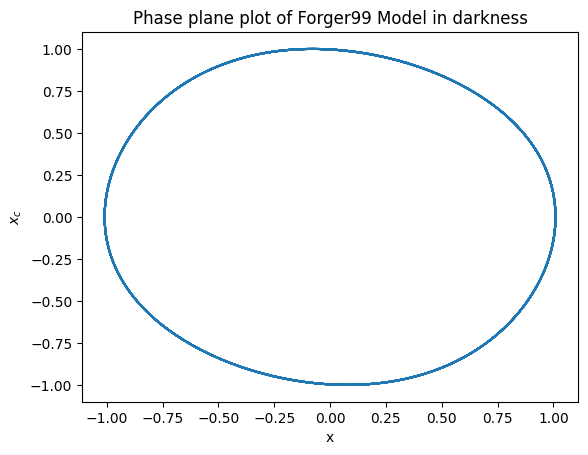

In [49]:
ts = np.arange(0, 24*7, 0.1)
light_values = np.zeros_like(ts) # simulate in darkness
fmodel = Forger99()

trajectory = fmodel(ts, light_values)

plt.plot(trajectory.states[:,0], trajectory.states[:,1])
plt.title("Phase plane plot of Forger99 Model in darkness")
plt.xlabel("x")
plt.ylabel("$x_c$");


We can also make a time plot of the dynamics

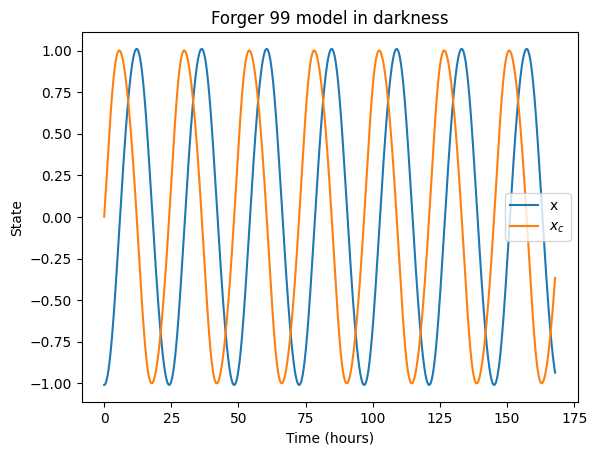

In [50]:
# Integrate observer for the Forger 99 model

plt.plot(trajectory.time, trajectory.states[:,0], label="x")
plt.plot(trajectory.time, trajectory.states[:,1], label="$x_c$")
plt.xlabel("Time (hours)")
plt.ylabel("State")
plt.title("Forger 99 model in darkness")
plt.legend()
plt.show();

We can also run a the model for a whole collection of initial conditions in one pass by just adding a batch dimension to the initial state. 
Here we show how to run the Forger model for 100 random initial conditions centered on an initial estimate. 

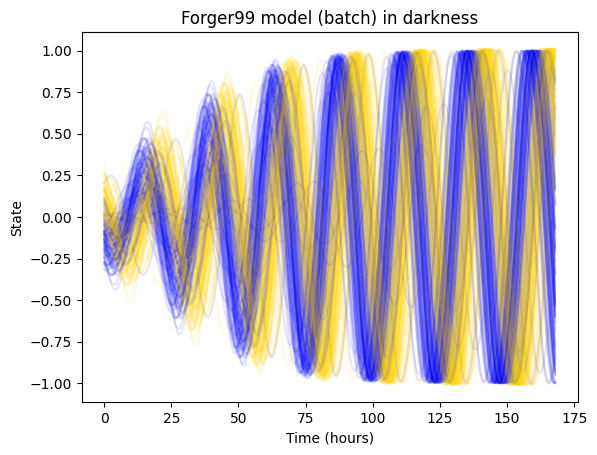

In [51]:
ts = np.arange(0, 24*7, 0.1)
light_values = np.zeros_like(ts) 
fmodel = Forger99()

initial_conditions_batch = np.reshape(np.array([0.10, -0.10, 0.0]), (3, 1)) + np.random.normal(0, 0.1, (3, 100))

trajectory = fmodel.integrate_model(ts, 
                             light_values, 
                             initial_conditions=initial_conditions_batch)

for i in range(100):
    plt.plot(trajectory.time, trajectory.states[:,1,i], color='blue', alpha=0.1)
    plt.plot(trajectory.time, trajectory.states[:,0,i], color='gold', alpha=0.1)
plt.xlabel("Time (hours)")
plt.ylabel("State")
plt.title("Forger99 model (batch) in darkness")
plt.show();

Because adding a batch dimension is just using larger numpy arrays with the same vectorized operations under the hood we can run fairly larg batches with very little performance cost

In [52]:
#| hide 
def benchmark(func):
    @wraps(func)
    def timeit_wrapper(*args, **kwargs):
        start_time = tm.perf_counter()
        result = func(*args, **kwargs)
        end_time = tm.perf_counter()
        total_time = end_time - start_time
        print(f'Function {func.__name__}{args} {kwargs} Took {total_time:.4f} seconds')
        return result
    return timeit_wrapper

In [53]:
@benchmark
def batched_run(batch_size: int):
    initial_conditions_batch = np.reshape(np.array([0.10, -0.10, 0.0]), (3, 1)) + np.random.normal(0, 0.1, (3, 100))
    sol = fmodel.integrate_model(ts, 
                             light_values, 
                             initial_conditions=initial_conditions_batch)

for i in [1, 10, 100, 500, 1000, 5000, 10000]:
    batched_run(i)

Function batched_run(1,) {} Took 0.3074 seconds
Function batched_run(10,) {} Took 0.2945 seconds
Function batched_run(100,) {} Took 0.2914 seconds
Function batched_run(500,) {} Took 0.2945 seconds
Function batched_run(1000,) {} Took 0.3025 seconds
Function batched_run(5000,) {} Took 0.2920 seconds
Function batched_run(10000,) {} Took 0.2911 seconds


We can also easily get predictions of the Dim Light Melatonin Onset (DLMO) and Core Body Temperature minimum (CBT). The time between these markers gives the period of the oscillator over that time frame. 



In [54]:
ts = np.arange(0, 24*7, 0.1)
light_values = np.zeros_like(ts) 
fmodel = Forger99()

trajectory = fmodel(ts, light_values)

cbt = fmodel.cbt()
dlmos = fmodel.dlmos()

print(f"Hours between CBTs: {np.diff(cbt)}")
print(f"Hours between DLMOs: {np.diff(dlmos)}")

Hours between CBTs: [24.2 24.2 24.2 24.2 24.2]
Hours between DLMOs: [24.2 24.2 24.2 24.2 24.2]


The values away from 24.2 give the period while the transients die away from the initial conditions, you can see that the *freerunning* period (period with no light time cues) is 24.2 which roughly matches the average value from experimental studies. 

We can adjust this by passing in a custom parameter for $\tau_x$ (taux)


In [55]:
fmodel_short_period = Forger99({'taux': 23.8})

trajectory = fmodel_short_period.integrate_model(ts, light_est=light_values)

dlmos = fmodel_short_period.dlmos()
cbt = fmodel_short_period.cbt()

print(f"Hours between DLMOs: {np.diff(dlmos)}")
print(f"Hours between CBTs: {np.diff(cbt)}")

Hours between DLMOs: [23.8 23.8 23.8 23.8 23.8 23.8]
Hours between CBTs: [23.8 23.8 23.8 23.8 23.8 23.8]


## Hannay19TP

This model defines the two population model from [@hannay_macroscopic_2019].Note, this model rotates counterclockwise in accordance with the usual convention in mathematics. The VDP family of models rotate clockwise. This can be confusing when trying
to compare phase plane plots between the models, but is fixable with a simple rotation.



In [56]:
#| export
class Hannay19TP(CircadianModel):
    """  The Hannay et al 2019 two population model, which models the ventral and dorsal SCN populations """

    def __init__(self, 
                 params: dict= None # Dict of parameters to set, the published values are used by default
                 ) -> None:
        # Set the parameters to the published values by default
        self._default_params()
        if params:
            self.set_parameters(params)
        
    def _default_params(self) -> None:
        """
            Stores the default parameters for the model as published in Hannet et al 2019
        """
        
        default_params = {'tauV': 24.25,
                          'tauD': 24.0,
                          'Kvv': 0.05, 
                          'Kdd': 0.04,
                          'Kvd': 0.05,
                          'Kdv': 0.01,
                          'gamma': 0.024,
                          'A1': 0.440068, 
                          'A2': 0.159136,
                          'BetaL': 0.06452, 
                          'BetaL2': -1.38935, 
                          'sigma': 0.0477375,
                          'G': 33.75, 
                          'alpha_0': 0.05, 
                          'delta': 0.0075,
                          'p': 1.5, 
                          'I0': 9325.0}

        self.set_parameters(default_params)
        
    def set_parameters(self, 
                       param_dict: dict # Dict of parameters to set
                       ) -> None:

        params = [
            'tauV',
            'tauD',
            'Kvv',
            'Kdd',
            "Kvd",
            "Kdv",
            'gamma',
            'A1',
            'A2',
            'BetaL',
            'BetaL2',
            'sigma',
            'G',
            'alpha_0',
            'delta',
            'p',
            'I0']

        for key, value in param_dict.items():
            setattr(self, key, value)
            
    def get_parameters_array(self) -> np.ndarray: # Parameters as a numpy array
        """
            Return a numpy array of the models current parameters
        """
        return np.array([self.tauV, self.tauD, self.Kvv, self.Kdd, self.Kvd, self.Kdv, self.gamma, self.BetaL, self.BetaL2, self.A1, self.A2, self.sigma, self.G, self.alpha_0, self.delta, self.p, self.I0 ])

    @property
    def get_parameters(self) -> dict:
    
        current_params = {
            'tauV': self.w0,
            'tauD': self.tauD,
            'Kvv': self.Kvv,
            'Kdd': self.Kdd,
            'Kdv': self.Kdv,
            'Kvd': self.Kdv,
            'gamma': self.gamma,
            'A1': self.A1,
            'A2': self.A2,
            'BetaL': self.BetaL,
            'BetaL2': self.BetaL2,
            'sigma': self.sigma,
            'G': self.G,
            'alpha_0': self.alpha_0,
            'delta': self.delta,
            'p': self.p,
            'I0': self.I0}

        return (current_params)

    def alpha0(self, 
               light: float # light intensity in lux
               ) -> float: # Processed light intensity measure
        """A helper function for modeling the light input processing"""
        return (self.alpha_0 * pow(light, self.p) /
                (pow(light, self.p) + self.I0))

    def derv(self, 
             y: np.ndarray, # state vector for the dynamical system (Rv, Rd, Psiv, Psid, n)
             light: float, # light intensity in lux
             ) -> np.ndarray: # derivative of the state vector

        Rv = y[...,0]
        Rd = y[...,1]
        Psiv = y[...,2]
        Psid = y[...,3]
        n = y[...,4]

        Bhat = self.G * (1.0 - n) * self.alpha0(light=light)

        LightAmp = self.A1 * 0.5 * Bhat * (1.0 - pow(Rv, 4.0)) * np.cos(Psiv + self.BetaL) + self.A2 * 0.5 * Bhat * Rv * (
            1.0 - pow(Rv, 8.0)) * np.cos(2.0 * Psiv + self.BetaL2)
        LightPhase = self.sigma * Bhat - self.A1 * Bhat * 0.5 * (pow(Rv, 3.0) + 1.0 / Rv) * np.sin(
            Psiv + self.BetaL) - self.A2 * Bhat * 0.5 * (1.0 + pow(Rv, 8.0)) * np.sin(2.0 * Psiv + self.BetaL2)

        dydt = np.zeros_like(y)
        dydt[...,0] = -self.gamma * Rv + self.Kvv / 2.0 * Rv * (1 - pow(Rv, 4.0)) + self.Kdv / 2.0 * Rd * (
            1 - pow(Rv, 4.0)) * np.cos(Psid - Psiv) + LightAmp
        dydt[...,1] = -self.gamma * Rd + self.Kdd / 2.0 * Rd * \
            (1 - pow(Rd, 4.0)) + self.Kvd / 2.0 * Rv * (1.0 - pow(Rd, 4.0)) * np.cos(Psid - Psiv)
        dydt[...,2] = 2.0 * np.pi / self.tauV + self.Kdv / 2.0 * Rd * \
            (pow(Rv, 3.0) + 1.0 / Rv) * np.sin(Psid - Psiv) + LightPhase
        dydt[...,3] = 2.0 * np.pi / self.tauD - self.Kvd / 2.0 * \
            Rv * (pow(Rd, 3.0) + 1.0 / Rd) * np.sin(Psid - Psiv)
        dydt[...,4] = 60.0 * (self.alpha0(light=light) * (1.0 - n) - self.delta * n)
        return dydt
    
    def dlmos(self, trajectory: DynamicalTrajectory) -> np.ndarray:
        return self.observer(trajectory, Hannay19TP.DLMOObs)
    
    def cbt(self, trajectory: DynamicalTrajectory) -> np.ndarray:
        return self.observer(trajectory, Hannay19TP.CBTObs)

    def observer(self, trajectory: np.ndarray, observer_func: callable) -> np.array:
        zero_crossings = np.where(np.diff(np.sign(observer_func(0.0, trajectory.states))))[0]
        return trajectory.ts[zero_crossings]

    def DLMOObs(t, state) -> float:
        return np.sin(0.5*(Hannay19TP.phase(state)-5*np.pi/12.0))
    
    def CBTObs(t, state) -> float:
        return np.sin(0.5*(Hannay19TP.phase(state)-np.pi))

    def amplitude(state):
        # Make this joint amplitude at some point 
        return(state[0])

    def phase(state):
        return(state[2])
    
    @staticmethod
    def phase_difference(state) -> float: # Phase difference between the two oscillators
        return state[2] - state[3]
    
    @property
    def default_initial_conditions(self) -> np.ndarray:
        return np.array([1.0,1.0,0.0,0.10,0.0])

In [57]:
show_doc(Hannay19TP.derv)

---

[source](https://github.com/khannay/circadian/blob/main/circadian/models.py#L442){target="_blank" style="float:right; font-size:smaller"}

### Hannay19TP.derv

>      Hannay19TP.derv (y:numpy.ndarray, light:float)

Right-hand-side of the differential equation model

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| y | ndarray | state vector for the dynamical system (Rv, Rd, Psiv, Psid, n) |
| light | float | light intensity in lux |
| **Returns** | **ndarray** | **derivative of the state vector** |

## Hannay19 

This file defines the Hannay et al single population model from [@hannay_macroscopic_2019]. It describes the circadian state using polar coordinates $(R, \psi)$ and features a slight modification of the process L light processing function used in the VDP family of models [@forger_simpler_1999]. The model is systematically derived from a high-dimensional model for each clock neuron [@hannay_macroscopic_2018]. 

Here are some marker states for that model (all equals should be read as approx)

CBT=DLMO+7hrs
CBT=DLMO_mid+2hrs
CBT=circadian phase pi in the model
DLMO=circadian phase 5pi/12=1.309 in the model
MelatoninOffset=DLMO+10hrs


In [59]:
spmodel = Hannay19()
default_ic = spmodel.default_initial_conditions

In [60]:
spmodel = Hannay19()
ts = np.arange(0, 24*7, 0.10)
light_values = np.zeros(len(ts))
trajectory= spmodel(ts, light_values, np.array([0.10, 0.0,0.0]))

plt.plot(trajectory.states[0,:]*np.cos(trajectory.states[1,:]), trajectory.states[0,:]*np.sin(trajectory.states[1,:]))
plt.title("Phase plot of the Hannay19 model")
plt.xlabel("R cos(Psi)")
plt.xlabel("R sin(Psi)")

AttributeError: 'Hannay19' object has no attribute '_CircadianModel__num_states'

Because of the way the integration code is written it is simple to run a collection of initial conditions through the model by just adding an batch dimension (terminology taken from the machine learning literature). This shows an example of running the model through 

In [ ]:
from circadian.lights import LightSchedule

In [ ]:
spmodel = Hannay19()

ts = np.arange(0, 24*5, 0.10)
light_func = LightSchedule.ShiftWork(days_on=3, days_off=4)
light_values = light_func(ts)
num_batches = 100
initial_conditions_batch = np.array([0.70, np.pi,0.0]) + np.random.randn(num_batches,3)*0.20

trajectory = spmodel(ts, light_values, initial_conditions_batch)
for batch_idx in range(num_batches):
    plt.plot(trajectory.ts / 24.0, trajectory.states[batch_idx, 0,:]*np.sin(trajectory.states[batch_idx,1,:]), color='blue', alpha=0.10)
plt.title(f"{num_batches} batches of initial conditions")
plt.xlabel("Time (days)")
plt.ylabel("R sin(Psi)");

In [ ]:
#| hide  
dlmos_batch = []
for batch_idx in range(trajectory.batch_size):
    btrajectory = trajectory.get_batch(batch_idx)
    dlmos_batch.append(spmodel.dlmos(btrajectory))
    
dlmos_batch = np.array(dlmos_batch, dtype=object)

In [ ]:
plt.hist((trajectory.states[:,1,-1] - np.mean(trajectory.states[:,1,-1])) , bins=20, color='blue', alpha=0.5, label="Ending phase dispersion");
plt.hist((trajectory.states[:,1,0] - np.mean(trajectory.states[:,1,0])) , bins=20, color='green', alpha=0.5, label="Starting phase dispersion");
plt.legend();

We can also easily run the model over an batch of parameters just by passing in an array for the value of the parameters. The only gotcha is that you also need to pass in initial conditions which the same batch dimension to ensure the array arithmetic works out in the integrator.  

In [ ]:
num_batches = 100
spmodel = Hannay19({ 'tau' : np.linspace(23.5,24.5, num_batches), 'A1' : 0.32 + 0.05*np.random.randn(num_batches) })
initial_conditions_batch = np.array([0.70, np.pi,0.0]) + np.zeros((num_batches,3))
light_func = LightSchedule.ShiftWork(days_on=2, days_off=5)
ts = np.arange(0, 24*14, 0.10)
light_values = light_func(ts)
trajectory = spmodel.integrate_model(ts, light_est=light_values, state=initial_conditions_batch)
for batch_idx in range(num_batches):
    plt.plot(trajectory.ts / 24.0, trajectory.states[batch_idx, 0,:]*np.sin(trajectory.states[batch_idx,1,:]), color='blue', alpha=0.10)
plt.title(f"{num_batches} batches of parameters")
plt.xlabel("Time (days)")
plt.ylabel("R sin(Psi)");

## Models Coming Soon

## Non Photic Model ( Hilaire 2007) 

This implements the model from [@hilaire_addition_2007]. It describes the circadian state using the $(x, x_c, n)$ variables as seen in the other VDP based models. This model also uses sleep-wake information as a non-photic input. 



In [ ]:
#| export 

class Hilaire2007(CircadianModel):
    
    def __init__(self, params: dict = None):
        self._default_params() 
        if params is not None:
            self.set_parameters(params)
    
    def _default_params(self) -> dict:
        self.tx = 24.2;
        self.G = 37;
        self.k = .55;
        self.mu = .13;
        self.beta = 0.007;
        self.q = 1/3;
        self.rho = 0.032;
        
        # Light Parameters
        self.I0 = 9500;
        self.p = 0.5;
        self.a0 = 0.1;

        # Reference Parameters for phases
        self.phi_xcx = -2.98;
        self.phi_ref = 0.97;
        self.CBTmin = self.phi_xcx + self.phi_ref;
         
    def alphaNonPhotic(self, light_values: np.array) -> np.array:
        """
        The non-photic process L function
        """
        return self.a0*(np.power(light_values/self.I0,self.p))*(light_values/(light_values+100.0));
    
    def derv(self, 
             t, # time in hours
             y: np.array, # current state of the model (x, x_c, n)
             light: float, # light estimate in lux
             wake: float, # wake estimate (0.0 = asleep, 1.0 = awake)
             ) -> np.ndarray:
        """
        The derivative function for the Hilaire2007 NonPhotic Model
        """
        x = y[...,0]
        xc = y[...,1]
        n = y[..., 2]
        
        Bh = self.G * (1 - n) * self.alphaNonPhotic(light_values=light);
        B = Bh * (1 - .4 * x) * (1 - .4 * xc);

        #From St. Hilaire (2007): sigma equals either 1 (for sleep/rest) or 0 (for wake/activity),
        sigma = 1.0 if wake < 0.5 else 0.0
        Nsh = self.rho*(1/3 - sigma);
        
        # I'm confused about this part of the model
        C = t % 24;
        CBTminlocal = self.CBTmin*24.0/(2*np.pi);
        psi_cx = C - CBTminlocal
        psi_cx = psi_cx % 24;
        
        if (psi_cx > 16.5 and psi_cx < 21):
            Ns = self.rho*(1/3) 
        else:
            Ns = Nsh*(1 - np.tanh(10*x));
        
        dydt = np.zeros_like(y)
        dydt[...,0] = np.pi / 12.0 * (xc + self.mu*((1/3)*x + (4/3)*np.power(x,3.0) - 256/105*np.power(x,7.0)) + B + Ns);
        dydt[...,1] = np.pi / 12.0 * (self.q*B*xc - x*(np.power((24/(0.99729*self.tx)),2) + self.k*B));
        dydt[...,2] = 60.0 * (self.alphaNonPhotic(light) * (1.0 - n) - self.beta * n)
        
        return dydt
    
    def step_rk4(self,
                 t: float, #current time in hours
                 state: np.ndarray, #dy/dt = f(y, t)
                 light: float, #light value at time t in lux
                 wake: float, #wake estimate at time t (0.0 = asleep, 1.0 = awake)
                 dt=0.10 #step size in hours 
                 ):
        """
            Return the state of the model assuming a constant light value, wake estimate
            for one time step and using a fourth order Runga-Kutta integrator to perform the step
        """
        k1 = self.derv(t, state, light=light, wake=wake)
        k2 = self.derv(t, state + k1 * dt / 2.0, light=light, wake=wake)
        k3 = self.derv(t, state + k2 * dt / 2.0, light=light, wake=wake)
        k4 = self.derv(t, state + k3 * dt, light=light, wake=wake)
        state = state + (dt / 6.0) * (k1 + 2.0*k2 + 2.0*k3 + k4)
        return state
    
    def integrate_model(self,
                        ts: np.ndarray,  # Array of time points, also determines step size of RK4 solver
                        light_est: np.ndarray,  # Array of light estimates, should be the same length as ts
                        wake_est: np.ndarray,  # Array of wake estimates, should be the same length as ts
                        state: np.ndarray,  # Initial state of the model
                        ) -> DynamicalTrajectory:
        n = len(ts)
        sol = np.zeros((*state.shape, n))
        sol[..., 0] = state
        for idx in range(1, n):
            state = self.step_rk4(ts[idx],
                state=state,
                light=light_est[idx],
                wake=wake_est[idx],
                dt=ts[idx]-ts[idx-1]
            )
            sol[..., idx] = state
        return DynamicalTrajectory(ts, sol)
    
    
    def cbt(self, trajectory: DynamicalTrajectory) -> np.ndarray:
        cbt_mins = find_peaks(-1*trajectory.states[0,:])[0] # min of x is the CBTmin
        return trajectory.ts[cbt_mins] + self.phi_ref
    
    def dlmos(self, trajectory: DynamicalTrajectory) -> np.ndarray:
        return self.cbt(trajectory) + self.dlmo_convert # dlmo is defines by a relationship to cbt for this model

    def amplitude(state) -> float:
        return np.sqrt(state[0]**2+state[1]**2)

    def phase(state) -> float:
        x= state[0] 
        y = state[1]*-1.0
        return np.angle(x + complex(0,1)*y)
        
    @property
    def default_initial_conditions(self) -> np.ndarray:
        return np.array([-0.3,-1.13,0.0])
    
    def __repr__(self) -> str:
        return self.__str__()
    
    def __str__(self) -> str:
        return "St. Hilaire 2007 NonPhotic Model"

In [ ]:
hmodel = Hilaire2007() 

print(hmodel.derv(0, hmodel.default_initial_conditions, 1000, 1.0))
print(hmodel.step_rk4(0, hmodel.default_initial_conditions, 1000, 1.0))

In [ ]:
sol = hmodel.integrate_model(np.arange(0, 24*100, 0.1),
                             np.random.rand(240*100), 
                             np.random.rand(240*100), 
                             hmodel.default_initial_conditions)

plt.plot(sol.states[0, :], sol.states[1,:]);
plt.title(hmodel.__str__());
plt.xlabel("x");
plt.ylabel("$x_c$");

## Kronauer-Jewett Model

From the revised limit cycle oscillator model paper.

In [ ]:
#| export 
class KronauerJewett(CircadianModel):
    """ 
        Higher order vdp model for the circadian clock 
    """
    
    def __init__(self, params: dict = None):
        self._default_params() 
        if params is not None:
            self.set_parameters(params)
        
    def _default_params(self) -> dict:
        self.taux = 24.2;
        self.G = 19.875;
        self.b = 0.013;
        self.k = .55;
        
        self.mu = .1300;
        self.q = 1.0/3;
        
        self.I0 = 9500;
        self.p = .6;
        self.a0 = 0.16;
        
        # Relational parameters to circadian markers
        self.phi_ref = 0.80; # relative to x min to get CBTmin, units of hours
        self.dlmo_convert = -7.0 #factor to convert from CBTmin to DLMO
        

    def alphaFunction(self, light_values: np.array) -> np.array:
        """
        Alpha process L function
        """
        return self.a0*(light_values/self.I0)**self.p;
    
    def derv(self, 
             y: np.array, #state vector (x, xc, n)
             light: float, #light value in lux
             ) -> np.array:
        
        x =y[..., 0]
        xc = y[..., 1]
        n = y[..., 2]
        
        alpha = self.alphaFunction(light);
        Bh = self.G*alpha*(1-n);
        B = Bh*(1-0.4*x)*(1-0.4*xc);
        
        dydt = np.zeros_like(y)
        dydt[...,0] = np.pi/12* (xc + self.mu*(1/3*x+4/3*x**3-256/105*x**7) + B);
        dydt[...,1] = np.pi/12* (self.q*B*xc - x*((24/(0.99729*self.taux))**2 + self.k*B));
        dydt[...,2] = 60*(alpha*(1-n) - self.b*n);
        
        return dydt
    
    def cbt(self, trajectory: DynamicalTrajectory) -> np.ndarray:
        cbt_mins = find_peaks(-1*trajectory.states[0,:])[0] # min of x is the CBTmin
        return trajectory.ts[cbt_mins] + self.phi_ref
    
    def dlmos(self, trajectory: DynamicalTrajectory) -> np.ndarray:
        return self.cbt(trajectory) + self.dlmo_convert # dlmo is defines by a relationship to cbt for this model

    def amplitude(state) -> float:
        return np.sqrt(state[0]**2+state[1]**2)

    def phase(state) -> float:
        x= state[0] 
        y = state[1]*-1.0
        return np.angle(x + complex(0,1)*y)
        
    @property
    def default_initial_conditions(self) -> np.ndarray:
        return np.array([-0.3,-1.13,0.0])
    
    def __repr__(self) -> str:
        return self.__str__()
    
    def __str__(self) -> str:
        return "KronauerJewett"

In [ ]:
kmodel = KronauerJewett({"taux": np.linspace(23.5,24.5, 100)})

ic = kmodel.default_initial_conditions + np.zeros((100, 3))
sim_days = 10
sol = kmodel(ts=np.arange(0, 24*sim_days, 0.1), light_est=np.zeros(240*sim_days), state=ic)

for batch_idx in range(sol.batch_size):
    plt.plot(sol.ts, sol.states[batch_idx, 1,:], color="darkgreen", alpha=0.1)

In [ ]:
np.diff(kmodel.cbt(sol.get_batch(0)))

In [ ]:
np.diff(kmodel.dlmos(sol.get_batch(0)))

## Phase Dynamics Model Nakao02 

[model](https://pubmed.ncbi.nlm.nih.gov/12375623/)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()